In [1]:
import numpy as np
import torch

from floody import data as D
from floody import floody as F

In [2]:
import corner as DFM
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline 

In [3]:
cuda = torch.cuda.is_available()
device = ("cuda:0" if cuda else "cpu")

In [14]:
nyc_zipcodes = np.array([10001, 10002, 10003, 10004, 10005, 10006, 10007, 10009, 10010, 10011, 10012, 10013, 10014, 10016, 10017, 10018, 10019, 10021, 10022, 10023, 10024, 10025, 10026, 10027, 10029, 10030, 10031, 10032, 10033, 10034, 10035, 10036, 10038, 10039, 10040, 10044, 10128, 11201, 11203, 11204, 11205, 11207, 11208, 11209, 11210, 11211, 11212, 11213, 11214, 11215, 11216, 11217, 11218, 11219, 11220, 11221, 11222, 11223, 11224, 11225, 11226, 11228, 11229, 11230, 11231, 11232, 11233, 11234, 11235, 11236, 11237, 11238, 11239, 11004, 11005, 11101, 11102, 11103, 11104, 11105, 11106, 11354, 11355, 11356, 11357, 11358, 11360, 11361, 11362, 11363, 11364, 11365, 11366, 11367, 11368, 11369, 11370, 11372, 11373, 11374, 11375, 11377, 11378, 11379, 11385, 11411, 11413, 11414, 11415, 11416, 11417, 11418, 11419, 11420, 11421, 11422, 11423, 11426, 11427, 11428, 11429, 11432, 11433, 11434, 11435, 11436, 11691, 11692, 11693, 11694, 11697, 10451, 10452, 10453, 10454, 10455, 10456, 10457, 10458, 10459, 10460, 10460, 10461, 10462, 10463, 10464, 10464, 10465, 10466, 10467, 10468, 10468, 10469, 10470, 10471, 10472, 10472, 10473, 10474, 10301, 10302, 10303, 10304, 10305, 10306, 10307, 10308, 10309, 10310, 10312, 10314])
# zipcode not in file: 10020, 10041, 10047, 10048, 11312, 11431, 11695, 11696, 10313, 10311, 11371
print(len(nyc_zipcodes))

171


In [15]:
nyc = D.read_zipshape(nyc_zipcodes)

# compile covariates:
1. mean_monthly_rainfall
2. flood_risk100
3. median_household_income
4. population
5. renter_fraction 
6. educated_fraction
7. white_fraction

These are the input for CausalFlow

In [16]:
X_2022 = D.get_X(np.array(nyc['ZIPCODE']).astype(int), # zipcodes
                 np.array(nyc['LATITUDE']).astype(float), # latitude
                 np.array(nyc['LONGITUDE']).astype(float), 
                 2022)
X_2030 = D.get_X(np.array(nyc['ZIPCODE']).astype(int), np.array(nyc['LATITUDE']).astype(float), 
                 np.array(nyc['LONGITUDE']).astype(float), 2030)
X_2040 = D.get_X(np.array(nyc['ZIPCODE']).astype(int), np.array(nyc['LATITUDE']).astype(float), 
                 np.array(nyc['LONGITUDE']).astype(float), 2040)
X_2052 = D.get_X(np.array(nyc['ZIPCODE']).astype(int), np.array(nyc['LATITUDE']).astype(float), 
                 np.array(nyc['LONGITUDE']).astype(float), 2052)

In [28]:
xlim = (-74.3, -73.675)
ylim = (40.475, 40.95)

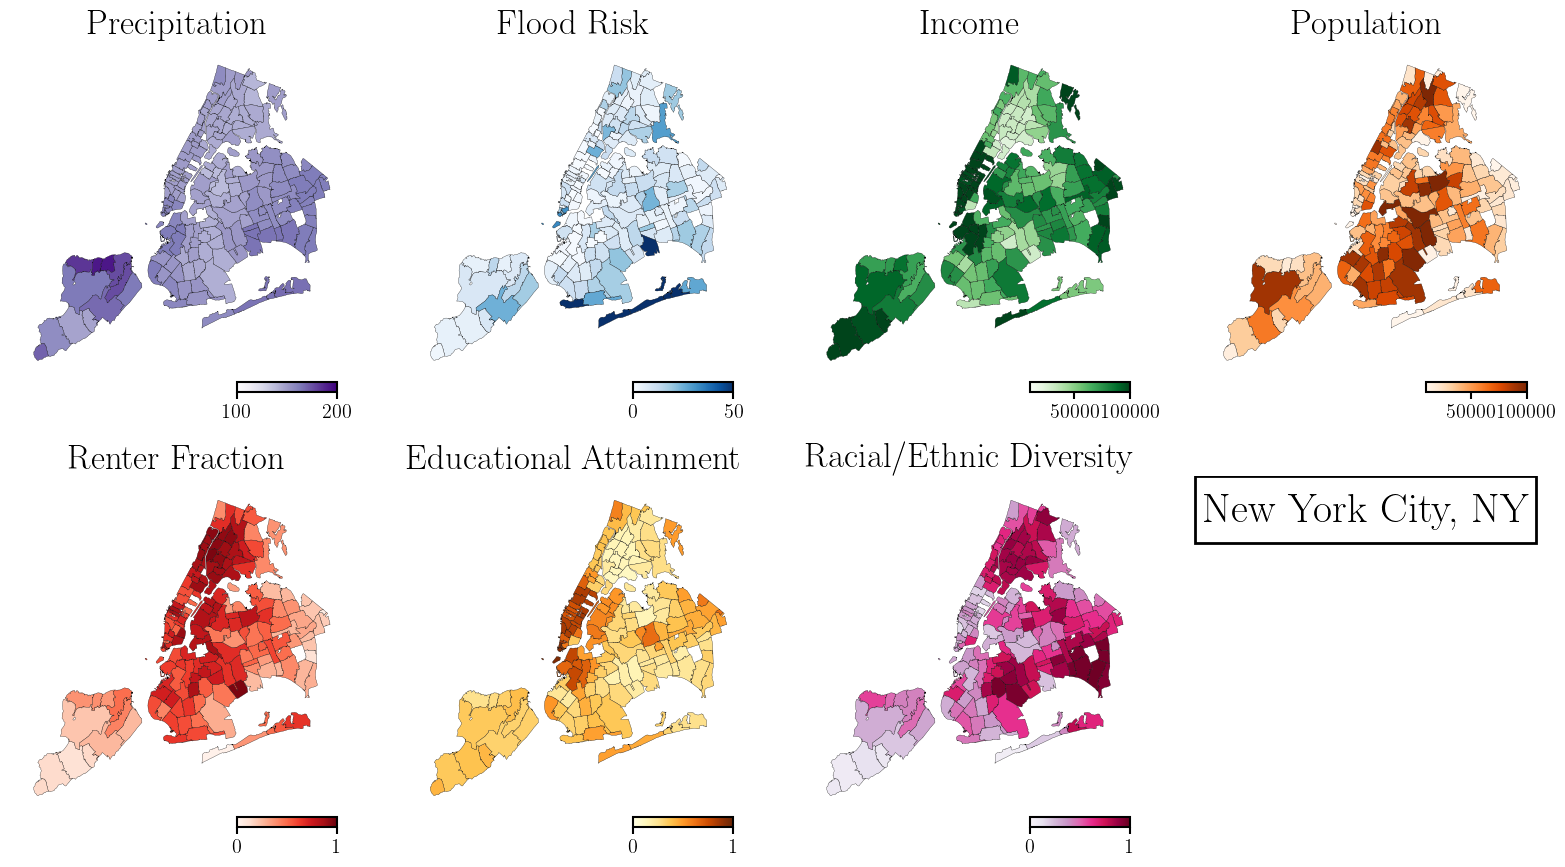

In [41]:
rng = [(100., 200.), (0., 50.), (1e4, 1e5), (1e4, 1e5), (0., 1.), (0., 1.), (0., 1.)]

fig = plt.figure(figsize=(20,10))
for i in range(7): 
    ax = fig.add_subplot(2,4,i+1)
    
    if i == 6: 
        nyc['blanck'] = 1.-X_2022[:,i]        
    else:
        nyc['blanck'] = X_2022[:,i]

    ax = nyc.plot(column='blanck', cmap=['Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'PuRd'][i],  edgecolor='k', linewidth=0.2, 
                      vmin=rng[i][0], vmax=rng[i][1], ax=ax)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    lbl = ['Precipitation', 'Flood Risk', 'Income', 'Population', 
           'Renter Fraction', 'Educational Attainment', r'Racial/Ethnic Diversity'][i]
    ax.text(0.5, 1., lbl, transform=ax.transAxes, ha='center', va='bottom', fontsize=25)
    ax.set_axis_off()
    
    sc = ax.scatter([], [], c=[], cmap=['Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'PuRd'][i], vmin=rng[i][0], vmax=rng[i][1])
    cbaxes = inset_axes(ax, width="30%", height="3%", 
                        bbox_to_anchor=(0, -1., 1, 1.),
                        bbox_transform=ax.transAxes)    
    cbar = plt.colorbar(sc, cax=cbaxes, orientation='horizontal')

ax = fig.add_subplot(2,4,8)
ax.text(0.05, 0.95, 'New York City, NY', transform=ax.transAxes, ha='left', va='top', fontsize=30)
rect = patches.Rectangle((0.025, 0.8), 0.945, 0.2, 
                         edgecolor='k', linewidth=2, facecolor='None', transform=ax.transAxes)
ax.add_patch(rect)
ax.set_axis_off()  

fig.subplots_adjust(hspace=0.3, wspace=0.1)

In [42]:
median_losses = np.zeros((4, X_2022.shape[0]))

for i, zcode in enumerate(np.array(nyc['ZIPCODE']).astype(int)): 
    for j, _X in enumerate([X_2022, X_2030, X_2040, X_2052]):
        _losses = F.flood_loss(_X[i,0], _X[i,1], _X[i,2], _X[i,3], _X[i,4], _X[i,5], _X[i,6],
                          Nsample=10000, support_threshold=0.99, device=None)
        median_losses[j, i] = np.median(_losses)
        
# save to file 
np.save('nyc.median_flood_losses.npy', median_losses)        

/home/chhahn/projects/floody/src/floody/floody.py:43: UserWarning: X is out of support
  if not in_support: warnings.warn("X is out of support")


In [ ]:
median_losses = np.load('nyc.median_flood_losses.npy')

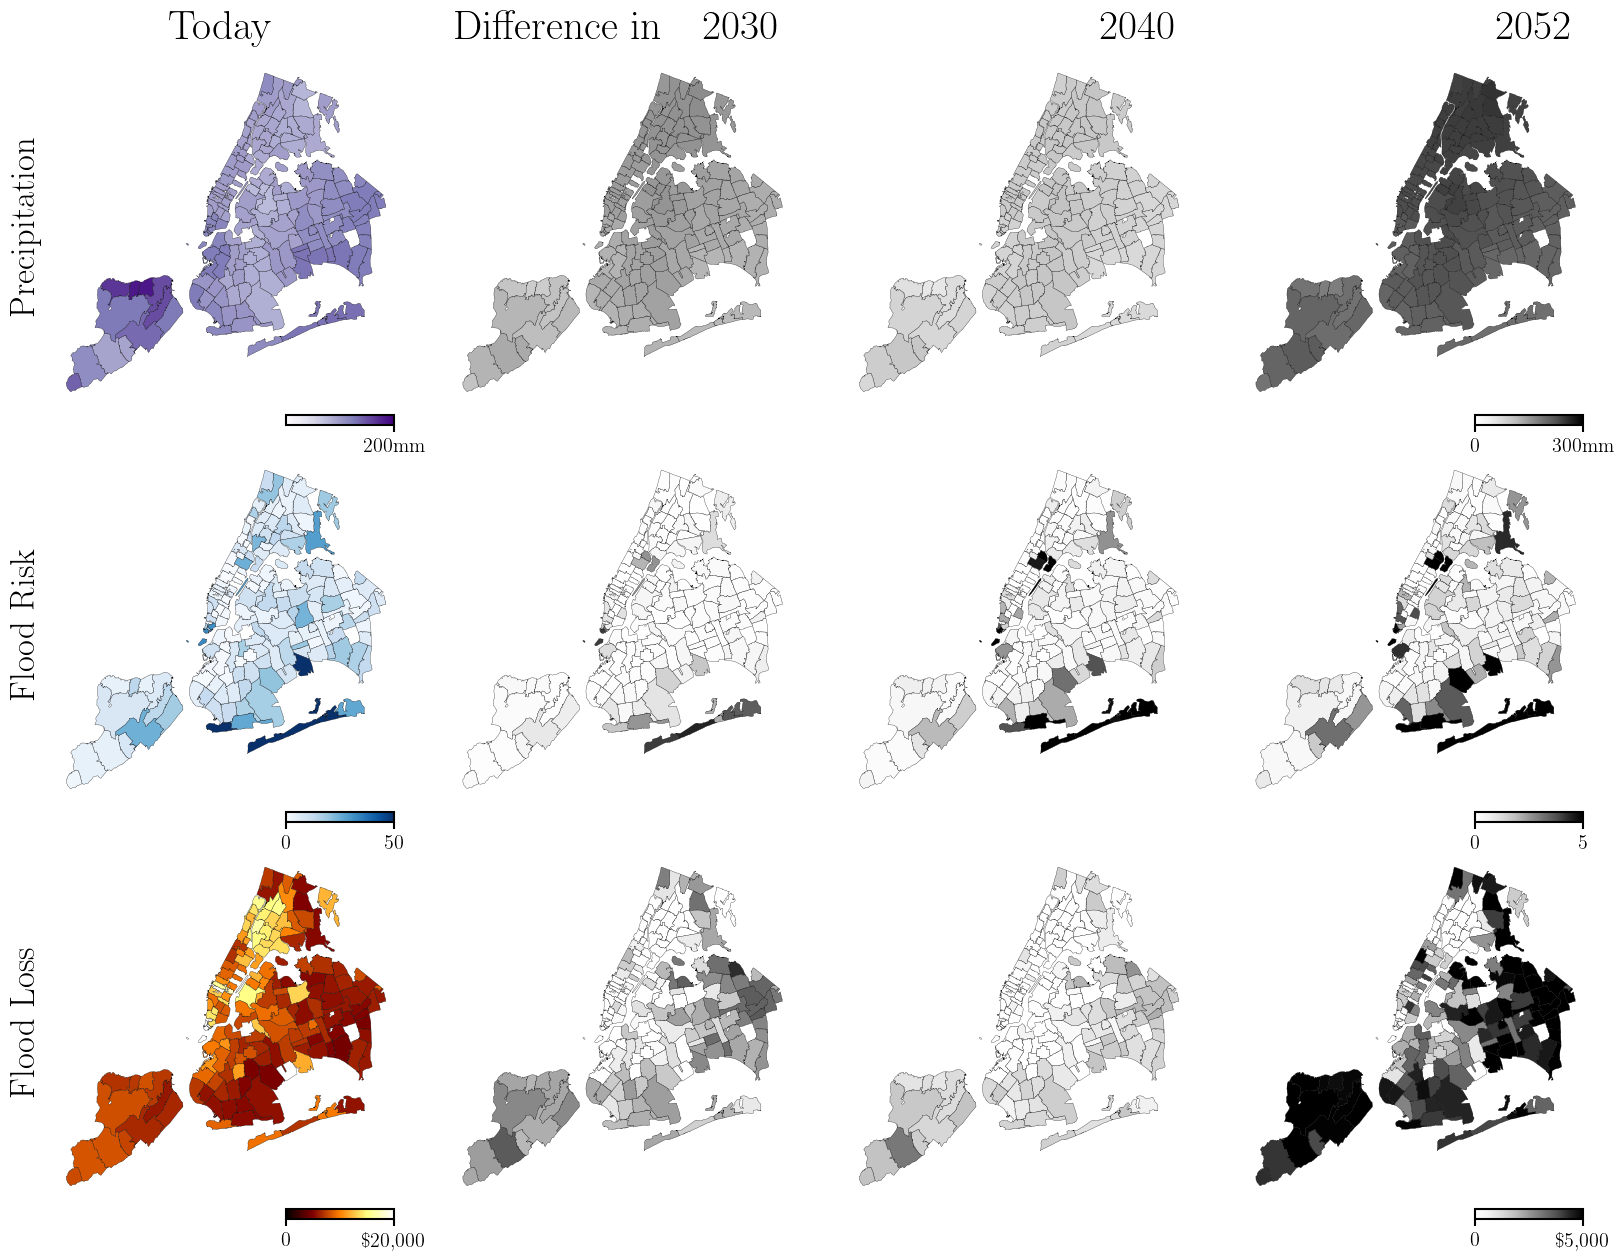

In [47]:
# create map figure and axes
fig = plt.figure(figsize=(20,15))
for i in range(4): 
    ax = fig.add_subplot(3,4,i+1)
    
    if i == 0: 
        nyc['blanck'] = X_2022[:,0]
    else: 
        nyc['blanck'] = ([None, X_2030, X_2040, X_2052][i])[:,0] - X_2022[:,0]
    ax = nyc.plot(column='blanck', cmap=['Greys', 'Purples'][i == 0], edgecolor='k', linewidth=0.2, 
                      vmin=[0., 100.][i == 0], vmax=[300., 200][i == 0], ax=ax)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    if i == 0: ax.text(0.0, 0.5, 'Precipitation', rotation=90., transform=ax.transAxes, ha='right', va='center', fontsize=25)
    if i == 1: ax.text(0.05, 1.0, 'Difference in', transform=ax.transAxes, ha='left', va='bottom', fontsize=30)
    ax.set_axis_off()
    if i == 0: ax.set_title('Today', fontsize=30)
    else: ax.text(0.95, 1.0, ['2030', '2040', '2052'][i-1], 
                  transform=ax.transAxes, ha='right', va='bottom', fontsize=30)    
    if i in [0, 3]: 
        sc = ax.scatter([], [], c=[], cmap=['Greys', 'Purples'][i == 0], 
                        vmin=[0., 100.][i == 0], vmax=[300., 200][i == 0])
        cbaxes = inset_axes(ax, width="30%", height="3%", 
                            bbox_to_anchor=(0, -1., 1, 1.),
                            bbox_transform=ax.transAxes) 
        cbar = plt.colorbar(sc, ticks=[0, [300., 200.][i==0]], cax=cbaxes, orientation='horizontal')
        cbar.ax.set_xticklabels(['0', ['300mm', '200mm'][i==0]])

    # Flood risk
    ax = fig.add_subplot(3,4,i+5)
    if i == 0: 
        nyc['blanck'] = X_2022[:,1]
    else: 
        nyc['blanck'] = ([None, X_2030, X_2040, X_2052][i])[:,1] - X_2022[:,1]
    
    ax = nyc.plot(column='blanck', cmap=['Greys', 'Blues'][i == 0], edgecolor='k', linewidth=0.2,  
                      vmin=[0., 0.][i == 0], vmax=[5., 50][i == 0], ax=ax)
    if i == 0: ax.axvline(-94.74, color='k', linewidth=1)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    if i == 0: ax.text(0.0, 0.5, 'Flood Risk', rotation=90., transform=ax.transAxes, ha='right', va='center', fontsize=25)
    #if i == 1: ax.text(0.05, 0.95, 'Differences', color='white', transform=ax.transAxes, ha='left', va='top', fontsize=25)
    ax.set_axis_off()
    
    if i in [0, 3]: 
        sc = ax.scatter([], [], c=[], cmap=['Greys', 'Blues'][i == 0], 
                        vmin=[0., 0.][i == 0], vmax=[5., 50][i == 0])
        cbaxes = inset_axes(ax, width="30%", height="3%", 
                            bbox_to_anchor=(0, -1., 1, 1.),
                            bbox_transform=ax.transAxes)
        cbar = plt.colorbar(sc, cax=cbaxes, orientation='horizontal')    

    
    # flood loss
    ax = fig.add_subplot(3,4,i+9)
    if i == 0: 
        nyc['blanck'] = median_losses[0,:]
    else: 
        nyc['blanck'] = median_losses[i,:] - median_losses[0,:]
    
    ax = nyc.plot(column='blanck', cmap=['Greys', 'afmhot'][i == 0], edgecolor='k', linewidth=0.2,  
                      vmin=[0., 0.][i == 0], vmax=[5e3, 2e4][i == 0], ax=ax)
    if i == 0: ax.axvline(-94.74, color='k', linewidth=1)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    if i == 0: ax.text(0.0, 0.5, 'Flood Loss', rotation=90., transform=ax.transAxes, ha='right', va='center', fontsize=25)
    #if i == 1: ax.text(0.05, 0.95, 'Differences', transform=ax.transAxes, ha='left', va='top', fontsize=25)
    ax.set_axis_off()
    
    if i in [0, 3]: 
        sc = ax.scatter([], [], c=[], cmap=['Greys', 'afmhot'][i == 0], 
                        vmin=[0., 0.][i == 0], vmax=[5e3, 2e4][i == 0])
        cbaxes = inset_axes(ax, width="30%", height="3%", 
                            bbox_to_anchor=(0, -1., 1, 1.),
                            bbox_transform=ax.transAxes)
        cbar = plt.colorbar(sc, ticks=[0, [5e3, 2e4][i == 0]], cax=cbaxes, orientation='horizontal')
        cbar.ax.set_xticklabels(['0', [r'\$5,000', r'\$20,000'][i==0]])
    
fig.subplots_adjust(hspace=0.1, wspace=0.1)

In [48]:
savings = []
for i, zcode in enumerate(np.array(nyc['ZIPCODE']).astype(int)): 
    _savings = []
    for j, _X in enumerate([X_2022, X_2030, X_2040, X_2052]):
        _saving = F.flood_saving(_X[i,0], _X[i,1], _X[i,2], _X[i,3], _X[i,4], _X[i,5], _X[i,6],
                          Nsample=10000, support_threshold=0.99, device=None)
        _savings.append(_saving)
    savings.append(_savings)
    
savings = np.array(savings)
# save to file 
np.save('nyc.flood_savings.npy', savings)

/home/chhahn/projects/CausalFlow/src/causalflow/causalflow.py:329: UserWarning: covariate is out of the treated sample support!
  warnings.warn("covariate is out of the treated sample support!")
/home/chhahn/projects/CausalFlow/src/causalflow/causalflow.py:331: UserWarning: covariate is out of the control sample support!
  warnings.warn("covariate is out of the control sample support!")


In [ ]:
savings = np.load('nyc.flood_savings.npy')

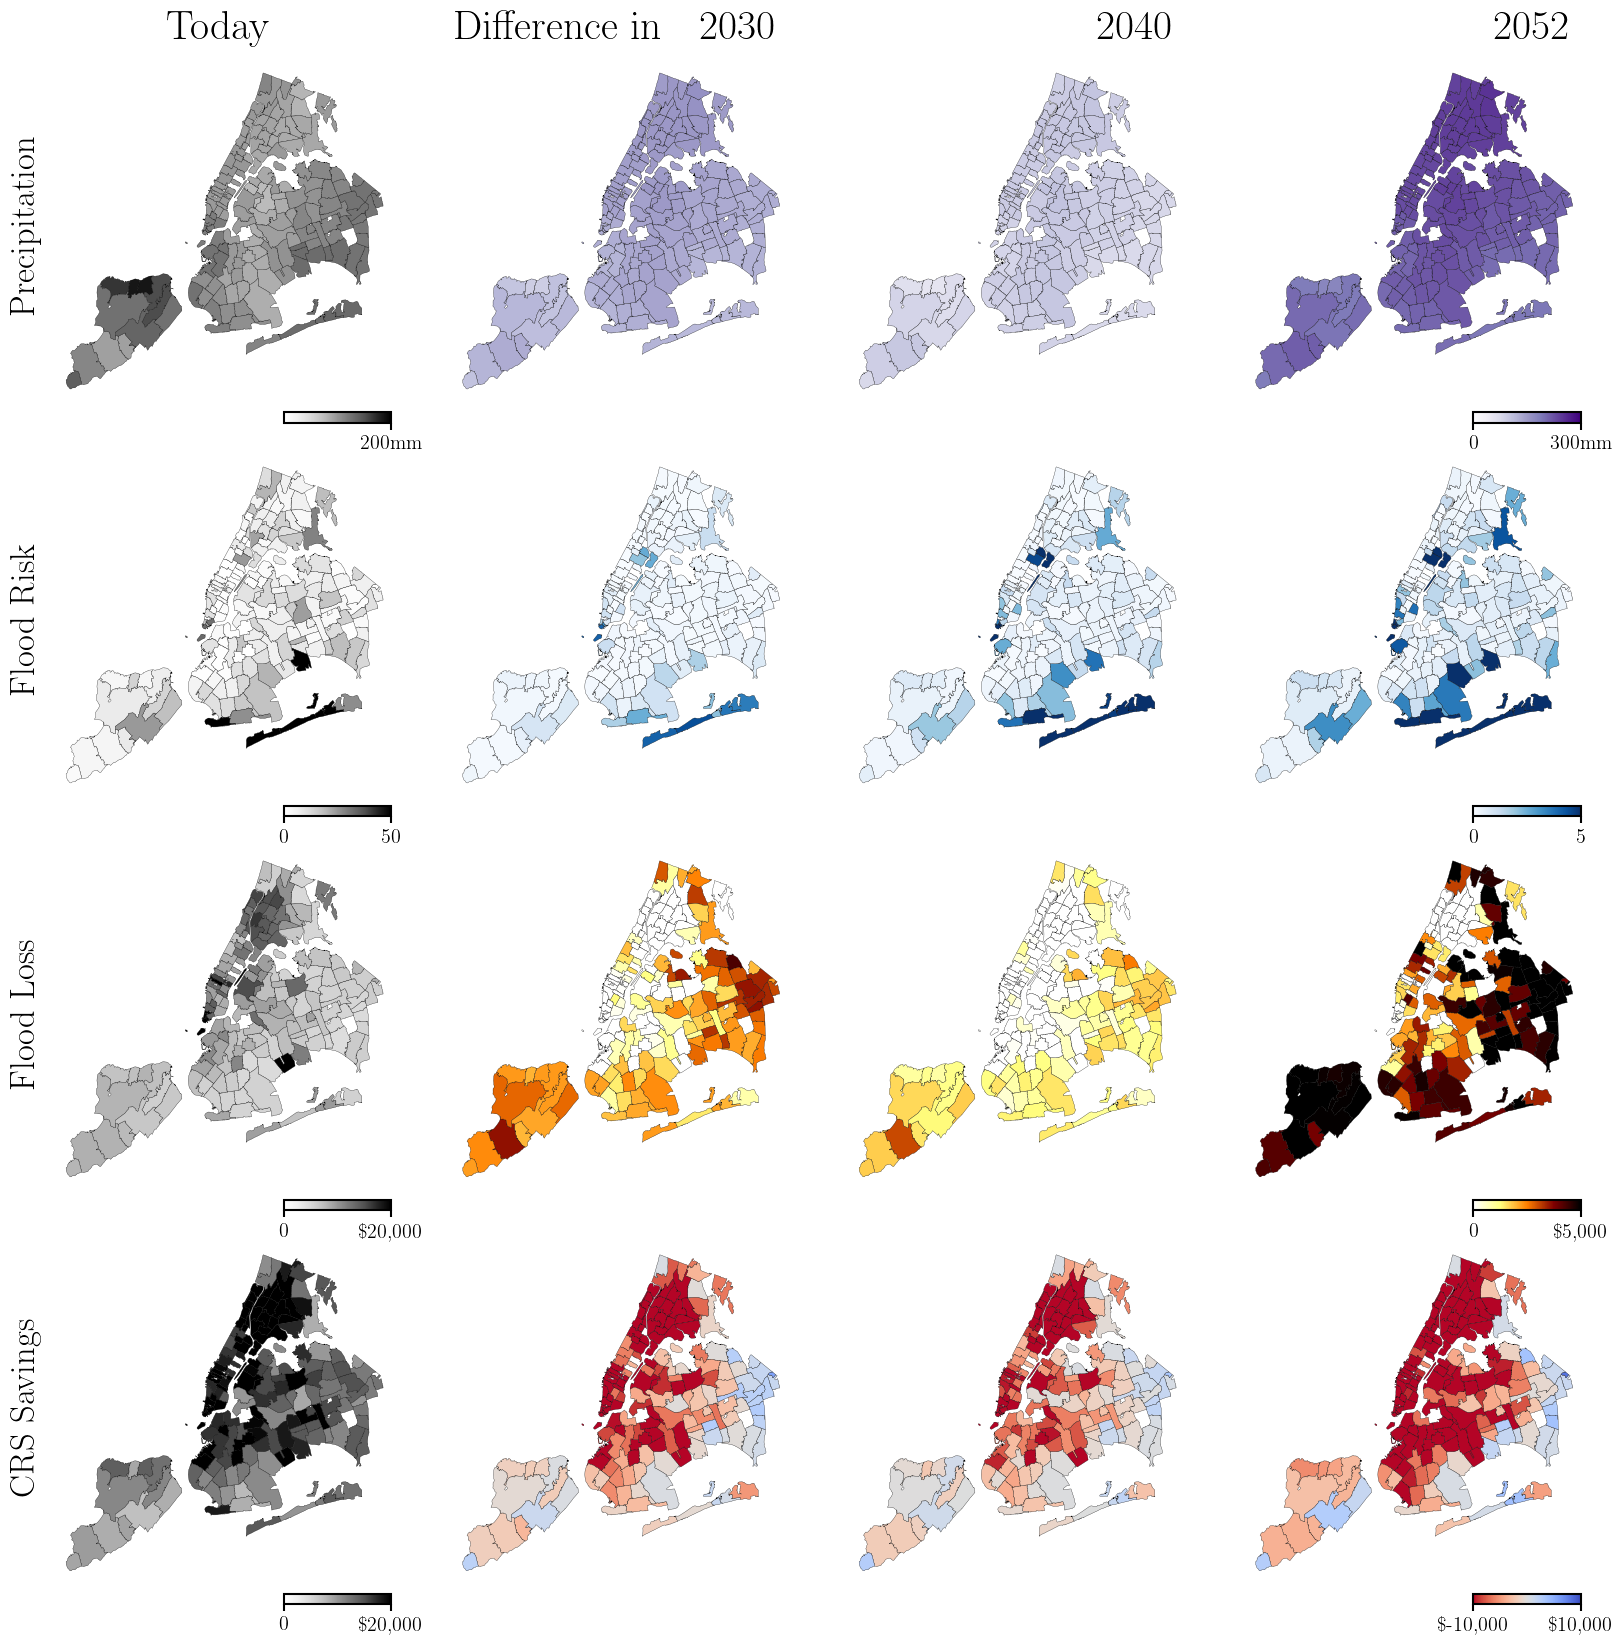

In [73]:
# create map figure and axes
fig = plt.figure(figsize=(20,20))
for i in range(4): 
    ax = fig.add_subplot(4,4,i+1)
    
    if i == 0: 
        nyc['blanck'] = X_2022[:,0]
    else: 
        nyc['blanck'] = ([None, X_2030, X_2040, X_2052][i])[:,0] - X_2022[:,0]
    ax = nyc.plot(column='blanck', cmap=['Greys', 'Purples'][i != 0], edgecolor='k', linewidth=0.2, 
                      vmin=[0., 100.][i == 0], vmax=[300., 200][i == 0], ax=ax)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    if i == 0: ax.text(0.0, 0.5, 'Precipitation', rotation=90., transform=ax.transAxes, ha='right', va='center', fontsize=25)
    if i == 1: ax.text(0.05, 1.0, 'Difference in', transform=ax.transAxes, ha='left', va='bottom', fontsize=30)
    ax.set_axis_off()
    if i == 0: ax.set_title('Today', fontsize=30)
    else: ax.text(0.95, 1.0, ['2030', '2040', '2052'][i-1], 
                  transform=ax.transAxes, ha='right', va='bottom', fontsize=30)    
    if i in [0, 3]: 
        sc = ax.scatter([], [], c=[], cmap=['Greys', 'Purples'][i != 0], 
                        vmin=[0., 100.][i == 0], vmax=[300., 200][i == 0])
        cbaxes = inset_axes(ax, width="30%", height="3%", 
                            bbox_to_anchor=(0, -1., 1, 1.),
                            bbox_transform=ax.transAxes) 
        cbar = plt.colorbar(sc, ticks=[0, [300., 200.][i==0]], cax=cbaxes, orientation='horizontal')
        cbar.ax.set_xticklabels(['0', ['300mm', '200mm'][i==0]])

    # Flood risk
    ax = fig.add_subplot(4,4,i+5)
    if i == 0: 
        nyc['blanck'] = X_2022[:,1]
    else: 
        nyc['blanck'] = ([None, X_2030, X_2040, X_2052][i])[:,1] - X_2022[:,1]
    
    ax = nyc.plot(column='blanck', cmap=['Greys', 'Blues'][i!=0], edgecolor='k', linewidth=0.2,  
                      vmin=[0., 0.][i==0], vmax=[5., 50][i==0], ax=ax)
    if i == 0: ax.axvline(-94.74, color='k', linewidth=1)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    if i == 0: ax.text(0.0, 0.5, 'Flood Risk', rotation=90., transform=ax.transAxes, ha='right', va='center', fontsize=25)
    #if i == 1: ax.text(0.05, 0.95, 'Differences', color='white', transform=ax.transAxes, ha='left', va='top', fontsize=25)
    ax.set_axis_off()
    
    if i in [0, 3]: 
        sc = ax.scatter([], [], c=[], cmap=['Greys', 'Blues'][i!=0], 
                        vmin=[0., 0.][i==0], vmax=[5., 50][i==0])
        cbaxes = inset_axes(ax, width="30%", height="3%", 
                            bbox_to_anchor=(0, -1., 1, 1.),
                            bbox_transform=ax.transAxes)
        cbar = plt.colorbar(sc, cax=cbaxes, orientation='horizontal')    

    
    # flood loss
    ax = fig.add_subplot(4,4,i+9)
    if i == 0: 
        nyc['blanck'] = median_losses[0,:]
    else: 
        nyc['blanck'] = median_losses[i,:] - median_losses[0,:]
    
    ax = nyc.plot(column='blanck', cmap=['Greys', 'afmhot_r'][i!=0], edgecolor='k', linewidth=0.2,  
                      vmin=[0., 0.][i==0], vmax=[5e3, 2e4][i==0], ax=ax)
    if i == 0: ax.axvline(-94.74, color='k', linewidth=1)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    if i == 0: ax.text(0.0, 0.5, 'Flood Loss', rotation=90., transform=ax.transAxes, ha='right', va='center', fontsize=25)
    #if i == 1: ax.text(0.05, 0.95, 'Differences', transform=ax.transAxes, ha='left', va='top', fontsize=25)
    ax.set_axis_off()
    
    if i in [0, 3]: 
        sc = ax.scatter([], [], c=[], cmap=['Greys', 'afmhot_r'][i!=0], 
                        vmin=[0., 0.][i==0], vmax=[5e3, 2e4][i==0])
        cbaxes = inset_axes(ax, width="30%", height="3%", 
                            bbox_to_anchor=(0, -1., 1, 1.),
                            bbox_transform=ax.transAxes)
        cbar = plt.colorbar(sc, ticks=[0, [5e3, 2e4][i==0]], cax=cbaxes, orientation='horizontal')
        cbar.ax.set_xticklabels(['0', [r'\$5,000', r'\$20,000'][i==0]])
        
        
    # CFS flood saving
    ax = fig.add_subplot(4,4,i+13)
    if i == 0: 
        nyc['blanck'] = -savings[:,0] + 9780.0 # outreach impact
    else: 
        nyc['blanck'] = -savings[:,i] + savings[:,0]
    
    ax = nyc.plot(column='blanck', cmap=['Greys', 'coolwarm_r'][i!=0], edgecolor='k', linewidth=0.2,  
                      vmin=[-10000., 0.][i==0], vmax=[10000, 2e4][i==0], ax=ax)
    if i == 0: ax.text(0.0, 0.5, 'CRS Savings', rotation=90., transform=ax.transAxes, ha='right', va='center', fontsize=25)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_axis_off()
    
    if i in [0, 3]: 
        sc = ax.scatter([], [], c=[], cmap=['Greys', 'coolwarm_r'][i!=0], 
                        vmin=[-10000., 0.][i==0], vmax=[10000, 2e4][i==0])
        cbaxes = inset_axes(ax, width="30%", height="3%", 
                            bbox_to_anchor=(0, -1., 1, 1.),
                            bbox_transform=ax.transAxes)
        cbar = plt.colorbar(sc, ticks=[[-10000., 0.][i==0], [10000, 2e4][i==0]], cax=cbaxes, orientation='horizontal')
        cbar.ax.set_xticklabels([[r'\$-10,000', '0'][i==0], [r'\$10,000', r'\$20,000'][i==0]])        
    
fig.subplots_adjust(hspace=0.1, wspace=0.1)